In [ ]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
import time
import numpy as np
from helper import *
import torch

In [ ]:
# Initialize processor and model
model_id = "llava-hf/llava-v1.6-vicuna-7b-hf"

quantization = False

processor = LlavaNextProcessor.from_pretrained(model_id)
model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    load_in_4bit=quantization,
)

if quantization is False: # hot fix for: .to` is not supported for `4-bit` or `8-bit` bitsandbytes models. 
    # Please use the model as it is, since the model has already been set to the correct devices and casted to the correct `dtype`.
    model = model.to("cuda:0")

In [ ]:
# ================ HiRED config ================
model.config.hired_config = {
    "token_budget_rate": 0.1, # 1.0 for full execution
    "alpha": 0.5,
}

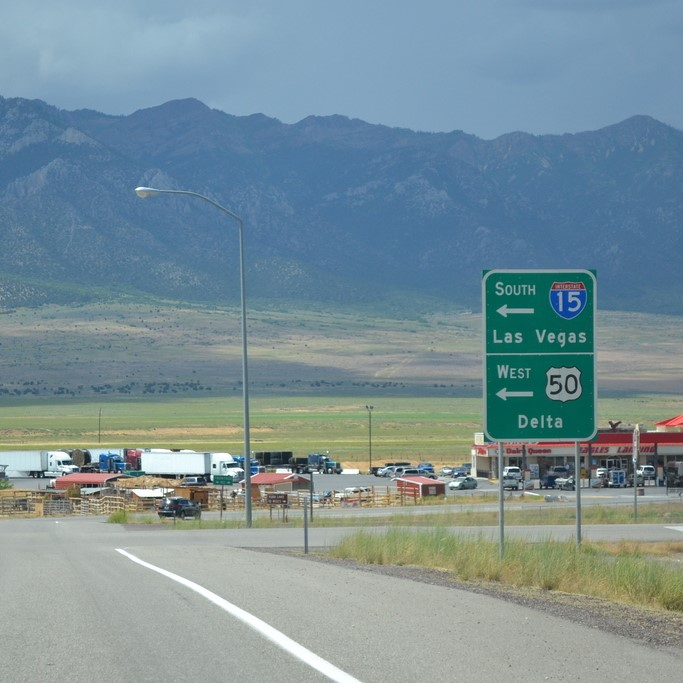

In [15]:
image = Image.open("./image.jpg")
# image = get_random_image(h=600, w=300)
image.show()
prompt = "USER: <image> \n What is this image about?\n ASSISTANT:"

In [16]:
start_time = time.time()
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")
with torch.inference_mode():
    output = model.generate(
        **inputs,
        do_sample=False,
        max_new_tokens=100,
        use_cache=True,
        return_dict_in_generate=True,
        )
output_text = processor.decode(output['sequences'][0], skip_special_tokens=False)
print(f"Output: {output_text}")
print(f"Time: {time.time() - start_time:.3f}s")

HiRED visual token count: torch.Size([287, 4096])


Output: <s> USER: <image> 
 What is this image about?
 ASSISTANT: The image shows a highway sign indicating the direction to various destinations. The sign is for Interstate 15, which is a major north-south freeway in the United States, running from the Mexican border at San Ysidro, California, to St. George, Utah. The sign also points to Las Vegas, which is a major city in Nevada, and Delta, which is a small town in Nevada. The sign also indicates the distance to
Time: 12.141s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9017585..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.5486543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


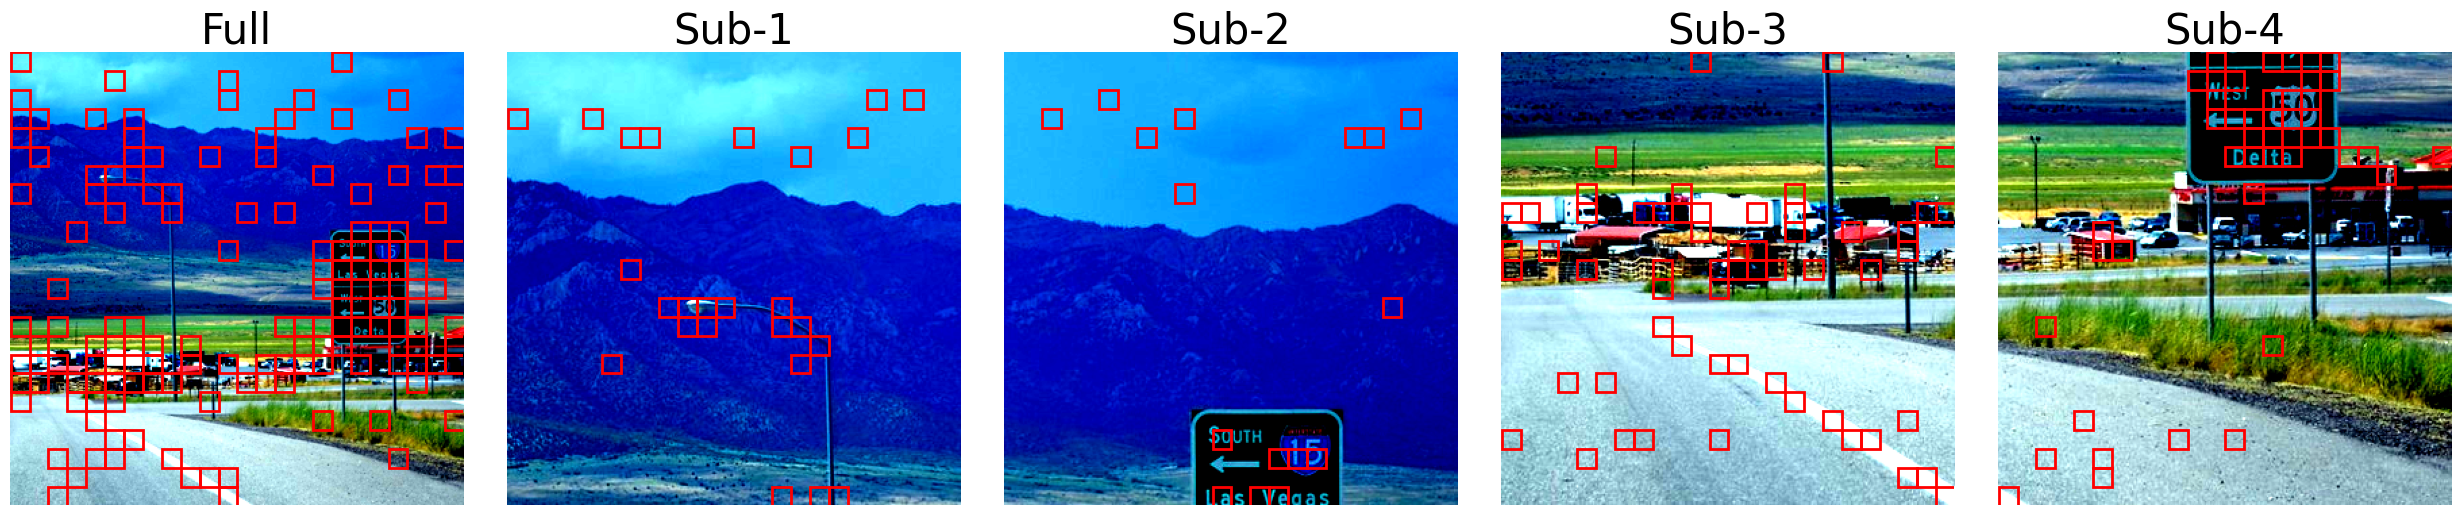

In [17]:
show_images_with_masks(model.pixel_values, model.selected_tokens_mask[0])